# Formulation 1: Channel-based Linear Utility Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

print("Gurobi Version:", gp.gurobi.version())

def generate_symmetric_correlation_matrix(N_ue, low=0.1, high=0.9, diagonal=0.0):
    # Random upper triangle
    upper = np.random.uniform(low, high, size=(N_ue, N_ue))
    symmetric = np.triu(upper, 1)  # Zero diagonal
    symmetric = symmetric + symmetric.T
    np.fill_diagonal(symmetric, diagonal)
    return symmetric

# Define the optimization model
model = gp.Model("ASSENT_model1")

# Input Parameters (Example Values)
N_ue, N_ap, N_t = 15, 6, 5
g_au = [[0.4 for _ in range(N_ue)] for _ in range(N_ap)]
g_at = [[0.6 for _ in range(N_t)] for _ in range(N_ap)]
g_tr = [[0.6 for _ in range(N_ap)] for _ in range(N_t)]
lambda_u = [0.1 for _ in range(N_ue)]
lambda_t = [0.2 for _ in range(N_t)]
mu = [0.2 for _ in range(N_ap)]
N_RF = [4 for _ in range(N_ap)]
rho = np.random.normal(0.2, 0.2, (N_ue, N_ue, N_ap))    # N_ue x N_ue
rho_th = 0.7
C_rx = [4 for _ in range(N_ap)] # maximum number of targets an AP can listen to


Gurobi Version: (12, 0, 3)
Set parameter Username
Set parameter LicenseID to value 2693565
Academic license - for non-commercial use only - expires 2026-08-04


In [2]:
# Decision Variables (binary)
x = model.addVars(N_ap, N_ue, vtype=GRB.BINARY, name="x")
y_tx = model.addVars(N_ap, N_t, vtype=GRB.BINARY, name="y_tx")
y_rx = model.addVars(N_t, N_ap, vtype=GRB.BINARY, name="y_rx")
tau = model.addVars(N_ap, vtype=GRB.BINARY, name="tau")
s = model.addVars(N_t, vtype=GRB.BINARY, name="s")

# Auxiliary Variables
z = model.addVars(N_ap, N_t, N_ap, vtype=GRB.BINARY, name="z")
w = model.addVars(N_ap, N_t, N_ap, vtype=GRB.BINARY, name="w")

In [3]:
# Constraints
# 1. AP Tx/Rx mode constraints
for a in range(N_ap):
    for u in range(N_ue):
        model.addConstr(x[a, u] <= tau[a])
    for t in range(N_t):
        model.addConstr(y_tx[a, t] <= tau[a])
        model.addConstr(y_rx[t, a] <= 1 - tau[a])

# 2. RF chain constraints
for a in range(N_ap):
    model.addConstr(gp.quicksum(x[a, u] for u in range(N_ue)) + gp.quicksum(y_tx[a, t] for t in range(N_t)) <= N_RF[a])

# 3. Target scheduling constraints
for t in range(N_t):
    model.addConstr(gp.quicksum(y_tx[a, t] for a in range(N_ap)) <= (N_ap - 1) * s[t])
    model.addConstr(gp.quicksum(y_rx[t, a] for a in range(N_ap)) >= s[t])

# 4. User-User correlation constraints
for a in range(N_ap):
    for u in range(N_ue):
        for u_ in range(N_ue):
            if u != u_: model.addConstr(x[a,u] + x[a,u_] <= 2 + rho_th - rho[u, u_, a])

# 5. Product linearization for z = s * y_tx * y_rx and w = y_tx * y_rx
for a_t in range(N_ap):
    for t in range(N_t):
        for a_r in range(N_ap):
            model.addConstr(w[a_t, t, a_r] <= y_tx[a_t, t])
            model.addConstr(w[a_t, t, a_r] <= y_rx[t, a_r])
            model.addConstr(w[a_t, t, a_r] >= y_tx[a_t, t] + y_rx[t, a_r] - 1)

            model.addConstr(z[a_t, t, a_r] <= s[t])
            model.addConstr(z[a_t, t, a_r] <= w[a_t, t, a_r])
            model.addConstr(z[a_t, t, a_r] >= s[t] + w[a_t, t, a_r] - 1)

# 6. Target reception constraints
for a in range(N_ap):
    model.addConstr(gp.quicksum(y_rx[t, a] for t in range(N_t)) <= C_rx[a])


In [4]:
# Objective Function

# Formulation 1: linear utility functions, directly using channel gains
comm_util = gp.quicksum(lambda_u[u] * g_au[a][u] * x[a,u] for a in range(N_ap) for u in range(N_ue))
sense_util = gp.quicksum(lambda_t[t] * g_at[a_t][t] * g_tr[t][a_r] * z[a_t,t,a_r] for a_t in range(N_ap) for a_r in range(N_ap) for t in range(N_t))


tx_reward = gp.quicksum(mu[a] * tau[a] for a in range(N_ap))

model.setObjective(comm_util + sense_util + tx_reward, GRB.MAXIMIZE)

# Optimize the model
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2512 rows, 521 columns and 5560 nonzeros
Model fingerprint: 0xed2c376d
Variable types: 0 continuous, 521 integer (521 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [4e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 1.2000000
Found heuristic solution: objective 2.1600000
Presolve removed 1900 rows and 220 columns
Presolve time: 0.01s
Presolved: 612 rows, 301 columns, 1390 nonzeros
Found heuristic solution: objective 2.0800000
Variable types: 0 continuous, 301 integer (301 binary)

Root relaxation: objective 6.360000e+00, 277 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

In [5]:
# Access values after solving

print("\nCommunication Associations (AP → Users):")
for a in range(N_ap):
    users_served = [u for u in range(N_ue) if x[a, u].X > 0.5]
    if users_served:
        print(f"- AP {a}: Users {users_served}")

print("\nSensing Illuminators (AP → Targets):")
for a in range(N_ap):
    targets_tx = [t for t in range(N_t) if y_tx[a, t].X > 0.5]
    if targets_tx:
        print(f"- AP {a} (Tx): Targets {targets_tx}")

print("\nSensing Receivers (AP ← Targets):")
for a in range(N_ap):
    targets_rx = [t for t in range(N_t) if y_rx[t, a].X > 0.5]
    if targets_rx:
        print(f"- AP {a} (Rx): Targets {targets_rx}")

print("\nScheduled Targets:")
for t in range(N_t):
    if s[t].X > 0.5:
        print(f"- Target {t} is scheduled")

print("\nAP Mode Assignments:")
for a in range(N_ap):
    mode = "Tx" if tau[a].X > 0.5 else "Rx"
    print(f"- AP {a}: {mode} mode")


Communication Associations (AP → Users):

Sensing Illuminators (AP → Targets):
- AP 0 (Tx): Targets [1, 2, 3, 4]
- AP 2 (Tx): Targets [1, 2, 3, 4]
- AP 4 (Tx): Targets [1, 2, 3, 4]

Sensing Receivers (AP ← Targets):
- AP 1 (Rx): Targets [1, 2, 3, 4]
- AP 3 (Rx): Targets [1, 2, 3, 4]
- AP 5 (Rx): Targets [1, 2, 3, 4]

Scheduled Targets:
- Target 1 is scheduled
- Target 2 is scheduled
- Target 3 is scheduled
- Target 4 is scheduled

AP Mode Assignments:
- AP 0: Tx mode
- AP 1: Rx mode
- AP 2: Tx mode
- AP 3: Rx mode
- AP 4: Tx mode
- AP 5: Rx mode


In [6]:
print("\n📊 AP Summary:")
for a in range(N_ap):
    mode = "Tx" if tau[a].X > 0.5 else "Rx"
    users_served = [u for u in range(N_ue) if x[a, u].X > 0.5]
    targets_tx = [t for t in range(N_t) if y_tx[a, t].X > 0.5]
    targets_rx = [t for t in range(N_t) if y_rx[t, a].X > 0.5]

    print(f"\n🔹 AP {a} ({mode})")
    if users_served:
        print(f"  - Serves users: {users_served}")
    if targets_tx:
        print(f"  - Illuminates targets: {targets_tx}")
    if targets_rx:
        print(f"  - Receives from targets: {targets_rx}")
    if not (users_served or targets_tx or targets_rx):
        print("  - No active associations")


📊 AP Summary:

🔹 AP 0 (Tx)
  - Illuminates targets: [1, 2, 3, 4]

🔹 AP 1 (Rx)
  - Receives from targets: [1, 2, 3, 4]

🔹 AP 2 (Tx)
  - Illuminates targets: [1, 2, 3, 4]

🔹 AP 3 (Rx)
  - Receives from targets: [1, 2, 3, 4]

🔹 AP 4 (Tx)
  - Illuminates targets: [1, 2, 3, 4]

🔹 AP 5 (Rx)
  - Receives from targets: [1, 2, 3, 4]


# Fromulation 2: Interference-aware Utility Functions

In [26]:

def generate_symmetric_correlation_matrix(N_ue, low=0.1, high=0.8, diagonal=0.0):
    # Random upper triangle
    upper = np.random.uniform(low, high, size=(N_ue, N_ue))
    symmetric = np.triu(upper, 1)  # Zero diagonal
    symmetric = symmetric + symmetric.T
    np.fill_diagonal(symmetric, diagonal)
    return symmetric

# Define the optimization model
model = gp.Model("ASSENT_model2")

# Input Parameters (Example Values)
N_ue, N_ap, N_t = 15, 6, 5
g_au = [[0.25 for _ in range(N_ue)] for _ in range(N_ap)]
g_at = [[0.4 for _ in range(N_t)] for _ in range(N_ap)]
g_tr = [[0.4 for _ in range(N_ap)] for _ in range(N_t)]
lambda_u = [0.18 for u in range(N_ue)]
lambda_t = [0.2 for t in range(N_t)]
mu = [0.1 for _ in range(N_ap)]
N_RF = [4 for _ in range(N_ap)]
rho = np.zeros((N_ue, N_ue, N_ap))  # N_ue x N_ue x N_ap
for a in range(N_ap):
    rho[:, :, a] = generate_symmetric_correlation_matrix(N_ue, low=0.1, high=0.8, diagonal=0.0)  # Generate correlation
rho_th = 0.7
C_rx = [4 for _ in range(N_ap)] # maximum number of targets an AP can listen to
interf_penalty_factor = 0.2  # Penalty factor for interference

# Decision Variables (binary)
x = model.addVars(N_ap, N_ue, vtype=GRB.BINARY, name="x")
y_tx = model.addVars(N_ap, N_t, vtype=GRB.BINARY, name="y_tx")
y_rx = model.addVars(N_t, N_ap, vtype=GRB.BINARY, name="y_rx")
tau = model.addVars(N_ap, vtype=GRB.BINARY, name="tau")
s = model.addVars(N_t, vtype=GRB.BINARY, name="s")

# Auxiliary Variables
z = model.addVars(N_ap, N_t, N_ap, vtype=GRB.BINARY, name="z")
w = model.addVars(N_ap, N_t, N_ap, vtype=GRB.BINARY, name="w")
v = model.addVars(N_ap, N_ue, N_ue, vtype=GRB.BINARY, name="v")

# Constraints
# 1. AP Tx/Rx mode constraints
for a in range(N_ap):
    for u in range(N_ue):
        model.addConstr(x[a, u] <= tau[a])
    for t in range(N_t):
        model.addConstr(y_tx[a, t] <= tau[a])
        model.addConstr(y_rx[t, a] <= 1 - tau[a])

# 2. RF chain constraints
for a in range(N_ap):
    model.addConstr(gp.quicksum(x[a, u] for u in range(N_ue)) + gp.quicksum(y_tx[a, t] for t in range(N_t)) <= N_RF[a])

# 3. Target scheduling constraints
for t in range(N_t):
    model.addConstr(gp.quicksum(y_tx[a, t] for a in range(N_ap)) <= (N_ap - 1) * s[t])
    model.addConstr(gp.quicksum(y_rx[t, a] for a in range(N_ap)) >= s[t])

# 4. User-User correlation constraints
for a in range(N_ap):
    for u in range(N_ue):
        for up in range(N_ue):
            if u < up: model.addConstr(x[a,u] + x[a,up] <= 2 + rho_th - rho[u, up, a])

# 5. Product linearization for z = s * y_tx * y_rx and w = y_tx * y_rx
for a_t in range(N_ap):
    for t in range(N_t):
        for a_r in range(N_ap):
            model.addConstr(w[a_t, t, a_r] <= y_tx[a_t, t])
            model.addConstr(w[a_t, t, a_r] <= y_rx[t, a_r])
            model.addConstr(w[a_t, t, a_r] >= y_tx[a_t, t] + y_rx[t, a_r] - 1)

            model.addConstr(z[a_t, t, a_r] <= s[t])
            model.addConstr(z[a_t, t, a_r] <= w[a_t, t, a_r])
            model.addConstr(z[a_t, t, a_r] >= s[t] + w[a_t, t, a_r] - 1)

# 6. Target reception constraints
for a in range(N_ap):
    model.addConstr(gp.quicksum(y_rx[t, a] for t in range(N_t)) <= C_rx[a])

# 7. Product linearization for v = x * x
for a in range(N_ap):
    for u in range(N_ue):
        for up in range(N_ue):
            if u == up:
                continue
            model.addConstr(v[a, u, up] <= x[a, u])
            model.addConstr(v[a, u, up] <= x[a, up])
            model.addConstr(v[a, u, up] >= x[a, u] + x[a, up] - 1)

# Objective Function

# Formulation 2: interference-aware linear channel-based utility functions
comm_util = (gp.quicksum(lambda_u[u] * g_au[a][u] * x[a,u] for a in range(N_ap) for u in range(N_ue))
             - interf_penalty_factor * gp.quicksum(((lambda_u[u]+lambda_u[up])/2) * rho[u, up, a] * g_au[a][u] * v[a, u, up] for a in range(N_ap) for u in range(N_ue) for up in range(N_ue) if u < up))
sense_util = gp.quicksum(lambda_t[t] * g_at[a_t][t] * g_tr[t][a_r] * z[a_t,t,a_r] for a_t in range(N_ap) for a_r in range(N_ap) for t in range(N_t))


tx_reward = gp.quicksum(mu[a] * tau[a] for a in range(N_ap))

model.setObjective(comm_util + sense_util + tx_reward, GRB.MAXIMIZE)

model.setParam("MIPGap", 0.02)
model.setParam("TimeLimit", 300)
# model.setParam("NodeLimit", 10000)

# Optimize the model
model.optimize()

Set parameter MIPGap to value 0.02
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M3 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.02

Optimize a model with 5662 rows, 1871 columns and 13120 nonzeros
Model fingerprint: 0xc78b6c39
Variable types: 0 continuous, 1871 integer (1871 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [9e-04, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 0.6000000
Found heuristic solution: objective 0.8700000
Presolve removed 4492 rows and 1013 columns
Presolve time: 0.02s
Presolved: 1170 rows, 858 columns, 3144 nonzeros
Variable types: 0 continuous, 858 integer (858 binary)

Root relaxation: objective 3.105000e+00, 707 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Curre

In [27]:
# Access values after solving

print("\nCommunication Associations (AP → Users):")
for a in range(N_ap):
    users_served = [u for u in range(N_ue) if x[a, u].X > 0.5]
    if users_served:
        print(f"- AP {a}: Users {users_served}")

print("\nSensing Illuminators (AP → Targets):")
for a in range(N_ap):
    targets_tx = [t for t in range(N_t) if y_tx[a, t].X > 0.5]
    if targets_tx:
        print(f"- AP {a} (Tx): Targets {targets_tx}")

print("\nSensing Receivers (AP ← Targets):")
for a in range(N_ap):
    targets_rx = [t for t in range(N_t) if y_rx[t, a].X > 0.5]
    if targets_rx:
        print(f"- AP {a} (Rx): Targets {targets_rx}")

print("\nScheduled Targets:")
for t in range(N_t):
    if s[t].X > 0.5:
        print(f"- Target {t} is scheduled")

print("\nAP Mode Assignments:")
for a in range(N_ap):
    mode = "Tx" if tau[a].X > 0.5 else "Rx"
    print(f"- AP {a}: {mode} mode")


Communication Associations (AP → Users):
- AP 0: Users [2, 6, 11, 14]
- AP 1: Users [0, 3, 4, 5]
- AP 2: Users [2, 5, 11, 12]
- AP 3: Users [0, 4, 6, 8]
- AP 4: Users [1, 3, 5, 7]
- AP 5: Users [3, 5, 8, 14]

Sensing Illuminators (AP → Targets):

Sensing Receivers (AP ← Targets):

Scheduled Targets:

AP Mode Assignments:
- AP 0: Tx mode
- AP 1: Tx mode
- AP 2: Tx mode
- AP 3: Tx mode
- AP 4: Tx mode
- AP 5: Tx mode


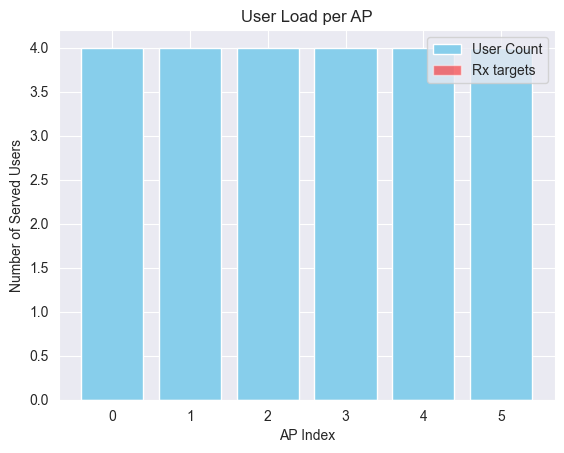

In [28]:
user_count_per_ap = [sum(x[a,u].x for u in range(N_ue)) for a in range(N_ap)]
plt.bar(range(N_ap), user_count_per_ap, color='skyblue', label='User Count')
rx_targets = [sum(y_rx[t, a].x for t in range(N_t)) for a in range(N_ap)]
plt.bar(range(N_ap), rx_targets, color='red', label='Rx targets', alpha=0.5)
plt.xlabel('AP Index')
plt.ylabel('Number of Served Users')
plt.title('User Load per AP')
plt.grid(True)
plt.legend()
plt.show()

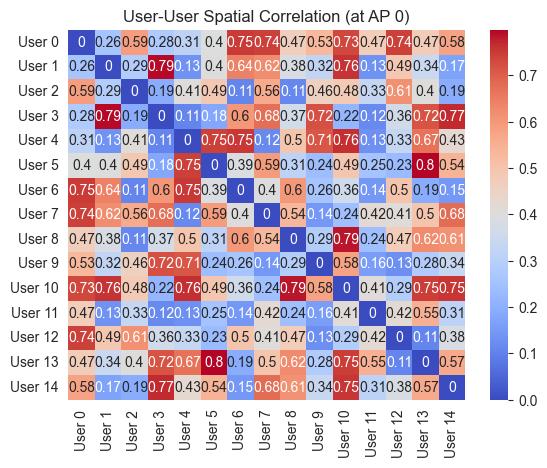

In [29]:
import seaborn as sns
ap_index = 0
user_ids = [f'User {u}' for u in range(N_ue)]
sns.heatmap(rho[:,:,ap_index], annot=True, cmap='coolwarm', xticklabels=user_ids, yticklabels=user_ids)
plt.title(f'User-User Spatial Correlation (at AP {ap_index})')
plt.show()